##  Постановка задачи

Домашнее задание по модулю ML-7 в рамках обучениия по профессии Data Scientist от SkillFactory.
В качестве исходной берется задача, по предсказанию биологического ответа молекул (столбец 'Activity' из файла с данными) по их химическому составу (столбцы D1-D1776).
Необходимо обучить две модели: логистическую регрессию и случайный лес. Далее нужно сделать подбор гиперпараметров с помощью базовых и продвинутых методов оптимизации. Важно использовать все четыре метода (GridSeachCV, RandomizedSearchCV, Hyperopt, Optuna) хотя бы по разу, максимальное количество итераций не должно превышать 50.

In [1]:
#импорт библиотек
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные моделиё
from sklearn import tree #деревья решений
from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #сплитование выборки

%matplotlib inline
plt.style.use('seaborn')

C:\Users\maimo\AppData\Local\Temp\ipykernel_34504\2150022218.py:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [3]:
data = pd.read_csv('_train_sem09.csv')

In [4]:
data.head() #проверяем, что все импортировалось корректно

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


Данные представлены в формате CSV.  Каждая строка представляет молекулу. 

Первый столбец Activity содержит экспериментальные данные, описывающие фактический биологический ответ [0, 1]; 
Остальные столбцы D1-D1776 представляют собой молекулярные дескрипторы — это вычисляемые свойства, которые могут фиксировать некоторые характеристики молекулы, например размер, форму или состав элементов.

Предварительная обработка не требуется, данные уже закодированы и нормализованы.

В качестве метрики будем использовать F1-score.

In [5]:
#Создаем матрицы с наблюдениями и вектор с результатми
X = data.drop(['Activity'], axis=1)
y = data['Activity']

Смотрим на сбалансированность классов:

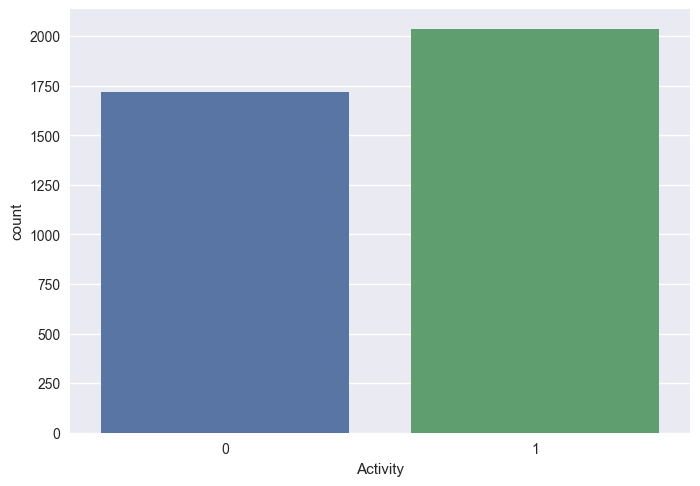

In [9]:
sns.countplot(data=data, x='Activity');

Разделяем выборку на тренировочную и тестовую в соотношении 80/20. Для сохранения соотношений целевого признака используем параметр stratify (стратифицированное разбиение), хотя скорее всего можно обойтись и без этого, так как соотношения 0 и 1 примерно 50 на 50. 

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 1, test_size = 0.2)

### Оптимизация гиперпараметров модели

#### **Логистическая регрессия**

Зафиксируем только метрики, которые были получены без дополнительной настройки, т.е со значениями гиперпараметров, установленных по умолчанию:

In [12]:
#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(max_iter = 1000)
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train, y_train)
print("accuracy на тестовом наборе: {:.2f}".format(log_reg.score(X_test, y_test)))
y_test_pred = log_reg.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.76
f1_score на тестовом наборе: 0.78


#### **RandomForrest**

In [13]:
#Создаем объект класса случайный лес
rf = ensemble.RandomForestClassifier(random_state=42)
#Обучаем модель
rf.fit(X_train, y_train)
#Выводим значения метрики 
y_train_pred = rf.predict(X_train)
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = rf.predict(X_test)
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Train: 1.00
Test: 0.81


### <center> <font color=Red> **GridSearchCV**

#### **Logistic Regression**

In [21]:
from sklearn.model_selection import GridSearchCV

param_grid = {'penalty': ['l1', 'l2'] ,#тип регурялизации
              'solver': ['liblinear', 'saga'], #алгоритм оптимизации
              }
grid_search = GridSearchCV(
    estimator=linear_model.LogisticRegression(
        random_state=42, #генератор случайных чисел
        max_iter=1000 #количество итераций на сходимость
    ), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search.fit(X_train, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(grid_search.score(X_test, y_test)))
y_test_pred = grid_search.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))
print("Наилучшее значение точности при кросс-валидации: {:.2f}".format(grid_search.best_score_))

CPU times: total: 125 ms
Wall time: 46.4 s
accuracy на тестовом наборе: 0.76
f1_score на тестовом наборе: 0.78
Наилучшие значения гиперпараметров: {'penalty': 'l2', 'solver': 'liblinear'}
Наилучшее значение точности при кросс-валидации: 0.75


#### **Random Forrest**

In [22]:
param_grid = {'n_estimators': list(range(80, 200, 30)),
              'min_samples_leaf': [5],
              'max_depth': list(np.linspace(20, 40, 5, dtype=int))
              }
            
grid_search1 = GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
grid_search1.fit(X_train, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(grid_search1.score(X_test, y_test)))
y_test_pred = grid_search1.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search1.best_params_))
print("Наилучшее значение точности при кросс-валидации: {:.2f}".format(grid_search1.best_score_))

accuracy на тестовом наборе: 0.80
f1_score на тестовом наборе: 0.82
Наилучшие значения гиперпараметров: {'max_depth': 20, 'min_samples_leaf': 5, 'n_estimators': 140}
Наилучшее значение точности при кросс-валидации: 0.78


### <center> <font color=Yellow> **RandomizedSearchCV**

#### **Logistic Regression**

In [23]:
from sklearn.model_selection import RandomizedSearchCV

param_distributions = {'penalty': ['l1', 'l2'] ,#тип регурялизации
              'solver': ['liblinear', 'saga'], #алгоритм оптимизации
               'C': list(np.linspace(0.01, 1, 10, dtype=float))},
            
random_search = RandomizedSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42, max_iter=1000), 
    param_distributions=param_distributions, 
    cv=5, 
    n_iter = 10, 
    n_jobs = -1
)  
%time random_search.fit(X_train, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(random_search.score(X_test, y_test)))
y_test_pred = random_search.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search.best_params_))

CPU times: total: 141 ms
Wall time: 1min 29s
accuracy на тестовом наборе: 0.77
f1_score на тестовом наборе: 0.79
Наилучшие значения гиперпараметров: {'solver': 'liblinear', 'penalty': 'l1', 'C': 0.23}


#### **Random Forrest**

In [24]:
param_distributions = {'n_estimators': list(range(80, 200, 30)),
              'min_samples_leaf': [5],
              'max_depth': list(np.linspace(20, 40, 10, dtype=int))
              }
            
random_search_forest = RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_distributions=param_distributions, 
    cv=5,
    n_iter = 10, 
    n_jobs = -1
)  
%time random_search_forest.fit(X_train, y_train) 
y_train_pred = random_search_forest.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на тестовом наборе: {:.2f}".format(random_search_forest.score(X_test, y_test)))
y_test_pred = random_search_forest.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search_forest.best_params_))

CPU times: total: 375 ms
Wall time: 8.61 s
f1_score на обучающем наборе: 0.94
accuracy на тестовом наборе: 0.81
f1_score на тестовом наборе: 0.83
Наилучшие значения гиперпараметров: {'n_estimators': 80, 'min_samples_leaf': 5, 'max_depth': 22}


### <center> <font color=Green> **Hyperopt**

#### **Logistic Regression**

In [25]:
from sklearn.model_selection import cross_val_score
import hyperopt
from hyperopt import hp, fmin, tpe, Trials

Настроим оптимизацию гиперпараметров для алгоритма логистической регрессии.

In [37]:
# зададим пространство поиска гиперпараметров
space={'penalty':  hp.choice('penalty',{'l1', 'l2'}),
       'solver':  hp.choice('solver',{'liblinear', 'saga'}),
       'C': hp.choice('C', {0.01,0.02,0.03,0.04,0.05,0.07,0.09,1}) # уровень силы регуляризации     
       }

In [51]:
# зафксируем random_state
random_state = 42
def hyperopt_lr(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'penalty': params['penalty'] ,#тип регурялизации
              'solver': params['solver'], #алгоритм оптимизации
               'C': params['C']}
  
    # используем эту комбинацию для построения модели
    model = linear_model.LogisticRegression(**params, random_state=42, max_iter=1000)

    # обучаем модель
    model.fit(X, y)
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [52]:

%%time

trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_lr, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=15, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

 73%|███████▎  | 11/15 [01:36<00:25,  6.50s/trial, best loss: -0.7856870897253121]

c:\Users\maimo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



100%|██████████| 15/15 [03:13<00:00, 12.89s/trial, best loss: -0.7856870897253121]
Наилучшие значения гиперпараметров {'C': 4, 'penalty': 0, 'solver': 0}
CPU times: total: 27.2 s
Wall time: 3min 13s


In [53]:
# рассчитаем точность для тестовой выборки
model = linear_model.LogisticRegression(
    random_state=random_state, 
    C=0.05,
    penalty='l1',
    solver = 'liblinear',
    max_iter=1000
)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test, y_test)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на обучающем наборе: 0.77
accuracy на тестовом наборе: 0.75
f1_score на тестовом наборе: 0.77


#### **Random Forrest**

In [54]:
# зададим пространство поиска гиперпараметров
space={'n_estimators': hp.quniform('n_estimators', 100, 200, 1),
       'max_depth' : hp.quniform('max_depth', 15, 26, 1),
       'min_samples_leaf': hp.quniform('min_samples_leaf', 2, 10, 1)
      }

In [60]:
# зафксируем random_state
random_state = 42
def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
             'min_samples_leaf': int(params['min_samples_leaf'])
              }
  
    # используем эту комбинацию для построения модели
    model = ensemble.RandomForestClassifier(**params, random_state=random_state)

    # обучаем модель
    model.fit(X, y)
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()
    
    return -score

In [62]:
%%time

trials_rf = Trials() # используется для логирования результатов

best_rf=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=20, # максимальное количество итераций
          trials=trials_rf, # логирование результатов
          rstate=np.random.default_rng(random_state)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best_rf))

100%|██████████| 20/20 [00:53<00:00,  2.69s/trial, best loss: -0.8080577050312506]
Наилучшие значения гиперпараметров {'max_depth': 18.0, 'min_samples_leaf': 2.0, 'n_estimators': 103.0}
CPU times: total: 6.78 s
Wall time: 53.7 s


In [63]:
# рассчитаем точность для тестовой выборки
model_rf = ensemble.RandomForestClassifier(
    random_state=random_state, 
    n_estimators=int(best_rf['n_estimators']),
    max_depth=int(best_rf['max_depth']),
    min_samples_leaf=int(best_rf['min_samples_leaf'])
)
model_rf.fit(X_train, y_train)
y_train_pred = model_rf.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на тестовом наборе: {:.2f}".format(model_rf.score(X_test, y_test)))
y_test_pred = model_rf.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на обучающем наборе: 0.99
accuracy на тестовом наборе: 0.80
f1_score на тестовом наборе: 0.82


### <center> <font color=Blue> **Optuna**

In [66]:
import optuna

c:\Users\maimo\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### **Logistic Regression**

In [68]:
def optuna_lg(trial):
  # задаем пространства поиска гиперпараметров
  penalty = trial.suggest_categorical('penalty', {'l1', 'l2'})
  solver = trial.suggest_categorical('solver', {'liblinear', 'saga'})
  C = trial.suggest_categorical('C', {0.01,0.02,0.03,0.04,0.05,0.07,0.09,1})

  # создаем модель
  model = linear_model.LogisticRegression(
    random_state=random_state, 
    C=C,
    penalty=penalty,
    solver = solver,
    max_iter=1000
)
  # обучаем модель
  model.fit(X_train, y_train)
  score = cross_val_score(model, X, y, cv=5, scoring="f1", n_jobs=-1).mean()

  return score


In [69]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="LogisticRegression", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_lg, n_trials=20)

[I 2022-12-26 15:31:18,510] A new study created in memory with name: LogisticRegression
[I 2022-12-26 15:31:23,145] Trial 0 finished with value: 0.7522687790497345 and parameters: {'penalty': 'l1', 'solver': 'saga', 'C': 0.02}. Best is trial 0 with value: 0.7522687790497345.
[I 2022-12-26 15:31:24,657] Trial 1 finished with value: 0.7631300938317868 and parameters: {'penalty': 'l1', 'solver': 'liblinear', 'C': 0.04}. Best is trial 1 with value: 0.7631300938317868.
[I 2022-12-26 15:31:35,094] Trial 2 finished with value: 0.7838901806138469 and parameters: {'penalty': 'l2', 'solver': 'saga', 'C': 0.01}. Best is trial 2 with value: 0.7838901806138469.
[I 2022-12-26 15:31:38,793] Trial 3 finished with value: 0.7522687790497345 and parameters: {'penalty': 'l1', 'solver': 'saga', 'C': 0.02}. Best is trial 2 with value: 0.7838901806138469.
[I 2022-12-26 15:31:55,121] Trial 4 finished with value: 0.7897124883823335 and parameters: {'penalty': 'l2', 'solver': 'saga', 'C': 0.04}. Best is trial 4

CPU times: total: 11.3 s
Wall time: 1min 28s


In [70]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'penalty': 'l2', 'solver': 'liblinear', 'C': 0.03}
f1_score на обучающем наборе: 0.79


In [71]:
# рассчитаем точность для тестовой выборки
model = linear_model.LogisticRegression(**study.best_params,random_state=42, max_iter=1000)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test, y_test)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.77
f1_score на тестовом наборе: 0.79


#### **Random Forrest**

In [72]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
  # обучаем модель
  model.fit(X_train, y_train)
  score = cross_val_score(model, X, y, cv=5, scoring="f1", n_jobs=-1).mean()

  return score
  

In [73]:
%%time
study_rf = optuna.create_study(study_name="RandomForrest", direction="maximize")
study_rf.optimize(optuna_rf, n_trials=20)

[I 2022-12-26 15:36:45,405] A new study created in memory with name: RandomForrest
[I 2022-12-26 15:36:48,123] Trial 0 finished with value: 0.8011221645185189 and parameters: {'n_estimators': 119, 'max_depth': 19, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.8011221645185189.
[I 2022-12-26 15:36:50,624] Trial 1 finished with value: 0.7996482626300357 and parameters: {'n_estimators': 103, 'max_depth': 20, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.8011221645185189.
[I 2022-12-26 15:36:52,938] Trial 2 finished with value: 0.7947816240999137 and parameters: {'n_estimators': 109, 'max_depth': 11, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.8011221645185189.
[I 2022-12-26 15:36:56,092] Trial 3 finished with value: 0.7958272272371877 and parameters: {'n_estimators': 166, 'max_depth': 10, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.8011221645185189.
[I 2022-12-26 15:36:58,422] Trial 4 finished with value: 0.8031140858559944 and parameters: {'n_estimator

CPU times: total: 9.09 s
Wall time: 1min 10s


In [74]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study_rf.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study_rf.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 194, 'max_depth': 29, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.82


In [75]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study_rf.best_params,random_state=random_state, )
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test, y_test)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.80
f1_score на тестовом наборе: 0.82


### Выводы. Проделана работа по оптимизации моделей машинного обучения, с помощью различных методов.